In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.image import ImagePromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.prompt_values import ImageURL
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain.output_parsers import PydanticOutputParser

In [55]:
class TagsForBoundingBoxes(BaseModel):
    
    detected_furnitures: list[str] = Field(..., description = "List of detected Furnitures");
    
    upper_left_axis_x: list[tuple([float, float])] = Field(..., description = "Upper-left axis of bounding boxes of detected furniture");
    upper_left_axis_y: list[tuple([float, float])] = Field(..., description = "Upper-left axis of bounding boxes of detected furniture");

    bottom_right_axis_x: list[tuple([float, float])] = Field(..., description = "Bottom-right axis of bounding boxes of detected furniture");
    bottom_right_axis_y: list[tuple([float, float])] = Field(..., description = "Bottom-right axis of bounding boxes of detected furniture");

class BoundingBoxGenerator:

    def __init__(self):
        
        self.GOOGLE_API_KEY = GOOGLE_API_KEY
        self.llm = ChatGoogleGenerativeAI(model = 'gemini-pro', google_api_key = self.GOOGLE_API_KEY,
                                         temperature = 0)
        self.lmm = ChatGoogleGenerativeAI(model = 'gemini-pro-vision', google_api_key = self.GOOGLE_API_KEY,
                                         temperature = 0)

        self.parser = PydanticOutputParser(pydantic_object = TagsForBoundingBoxes)
        self.prompt = PromptTemplate(
            template = """Allocated raw query to formatted instruction \n {format_instructions}\n{query}
            Note that the sequence formed like this : something | x, y | z, w
            """,
            input_variables = ["query"],
            partial_variables = {"format_instructions" : self.parser.get_format_instructions()}
        )

    def query_img(self, url:str = None):

        self.message = HumanMessage(
            content = [
                {'type': 'text',
                 'text': """You detect objects in the given image and provide their bounding box coordinates, but you must follow these rules:

                1. Do not suggest all objects; only include those that could be classified to **furniture** or **home appliance** items. For example, you should exclude windows or animals from the objects you present.
                2. For the coordinates, you should provide them in the form of the top-left and bottom-right points of the bounding box.
                3. If the objects do not fall under the categories of furniture or decorative items, you do not need to present anything.
                4. The coordinates must be presented as relative values to original width and height, ranging from 0 to 1. Do not use absolute values like 210, 850.
                5. The output must be presented in the format specified, listing the object, top-left coordinate, and bottom-right coordinate repeatedly.
                 """}
                ,
                {'type' : 'image_url',
                 'image_url' : url}
            ]           
        )
        
        self.raw_detected = self.lmm.invoke([self.message]).content

        chain = self.prompt | self.llm | self.parser
        raw_axis = chain.invoke({"query" : self.raw_detected})
        raw_axis_upper_left = list(zip(raw_axis.upper_left_axis_x, raw_axis.upper_left_axis_y))
        raw_axis_bottom_right = list(zip(raw_axis.bottom_right_axis_x, raw_axis.bottom_right_axis_y))
        return dict(zip(raw_axis.detected_furnitures, raw_axis_upper_left)),\
        dict(zip(raw_axis.detected_furnitures, raw_axis_bottom_right))

In [56]:
bbg = BoundingBoxGenerator()
output_bbg = bbg.query_img(url = 'https://image.ohou.se/i/bucketplace-v2-development/uploads/cards/snapshots/169087905318351049.jpeg')


In [64]:
print(output_bbg[0], output_bbg[1])

{'TV': (0.05, 0.25), 'Fan': (0.01, 0.25), 'Sofa': (0.35, 0.4), 'Ottoman': (0.6, 0.55), 'Air purifier': (0.85, 0.4)} {'TV': (0.25, 0.75), 'Fan': (0.05, 0.55), 'Sofa': (0.75, 0.75), 'Ottoman': (0.7, 0.65), 'Air purifier': (0.95, 0.7)}


In [78]:
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO

def draw_rectangles(url:str, upper_left_dict:dict, bottom_right_dict:dict):
    
    res = requests.get(url)
    img = Image.open(BytesIO(res.content))
    draw = ImageDraw.Draw(img)

    width = img.width; height = img.height
    font = ImageFont.load_default()    

    for item in upper_left_dict.keys():

        outline_color = 'red'; text_color = 'blue'
        
        upper_left_axis = (int(upper_left_dict[item][0] * width), int(upper_left_dict[item][1] * height))
        bottom_right_axis = (int(bottom_right_dict[item][0] * width), int(bottom_right_dict[item][1] * height))
        draw.rectangle([upper_left_axis, bottom_right_axis], outline = outline_color, width = 2)
        draw.text(upper_left_axis, item, fill = text_color, font = font)

    return img

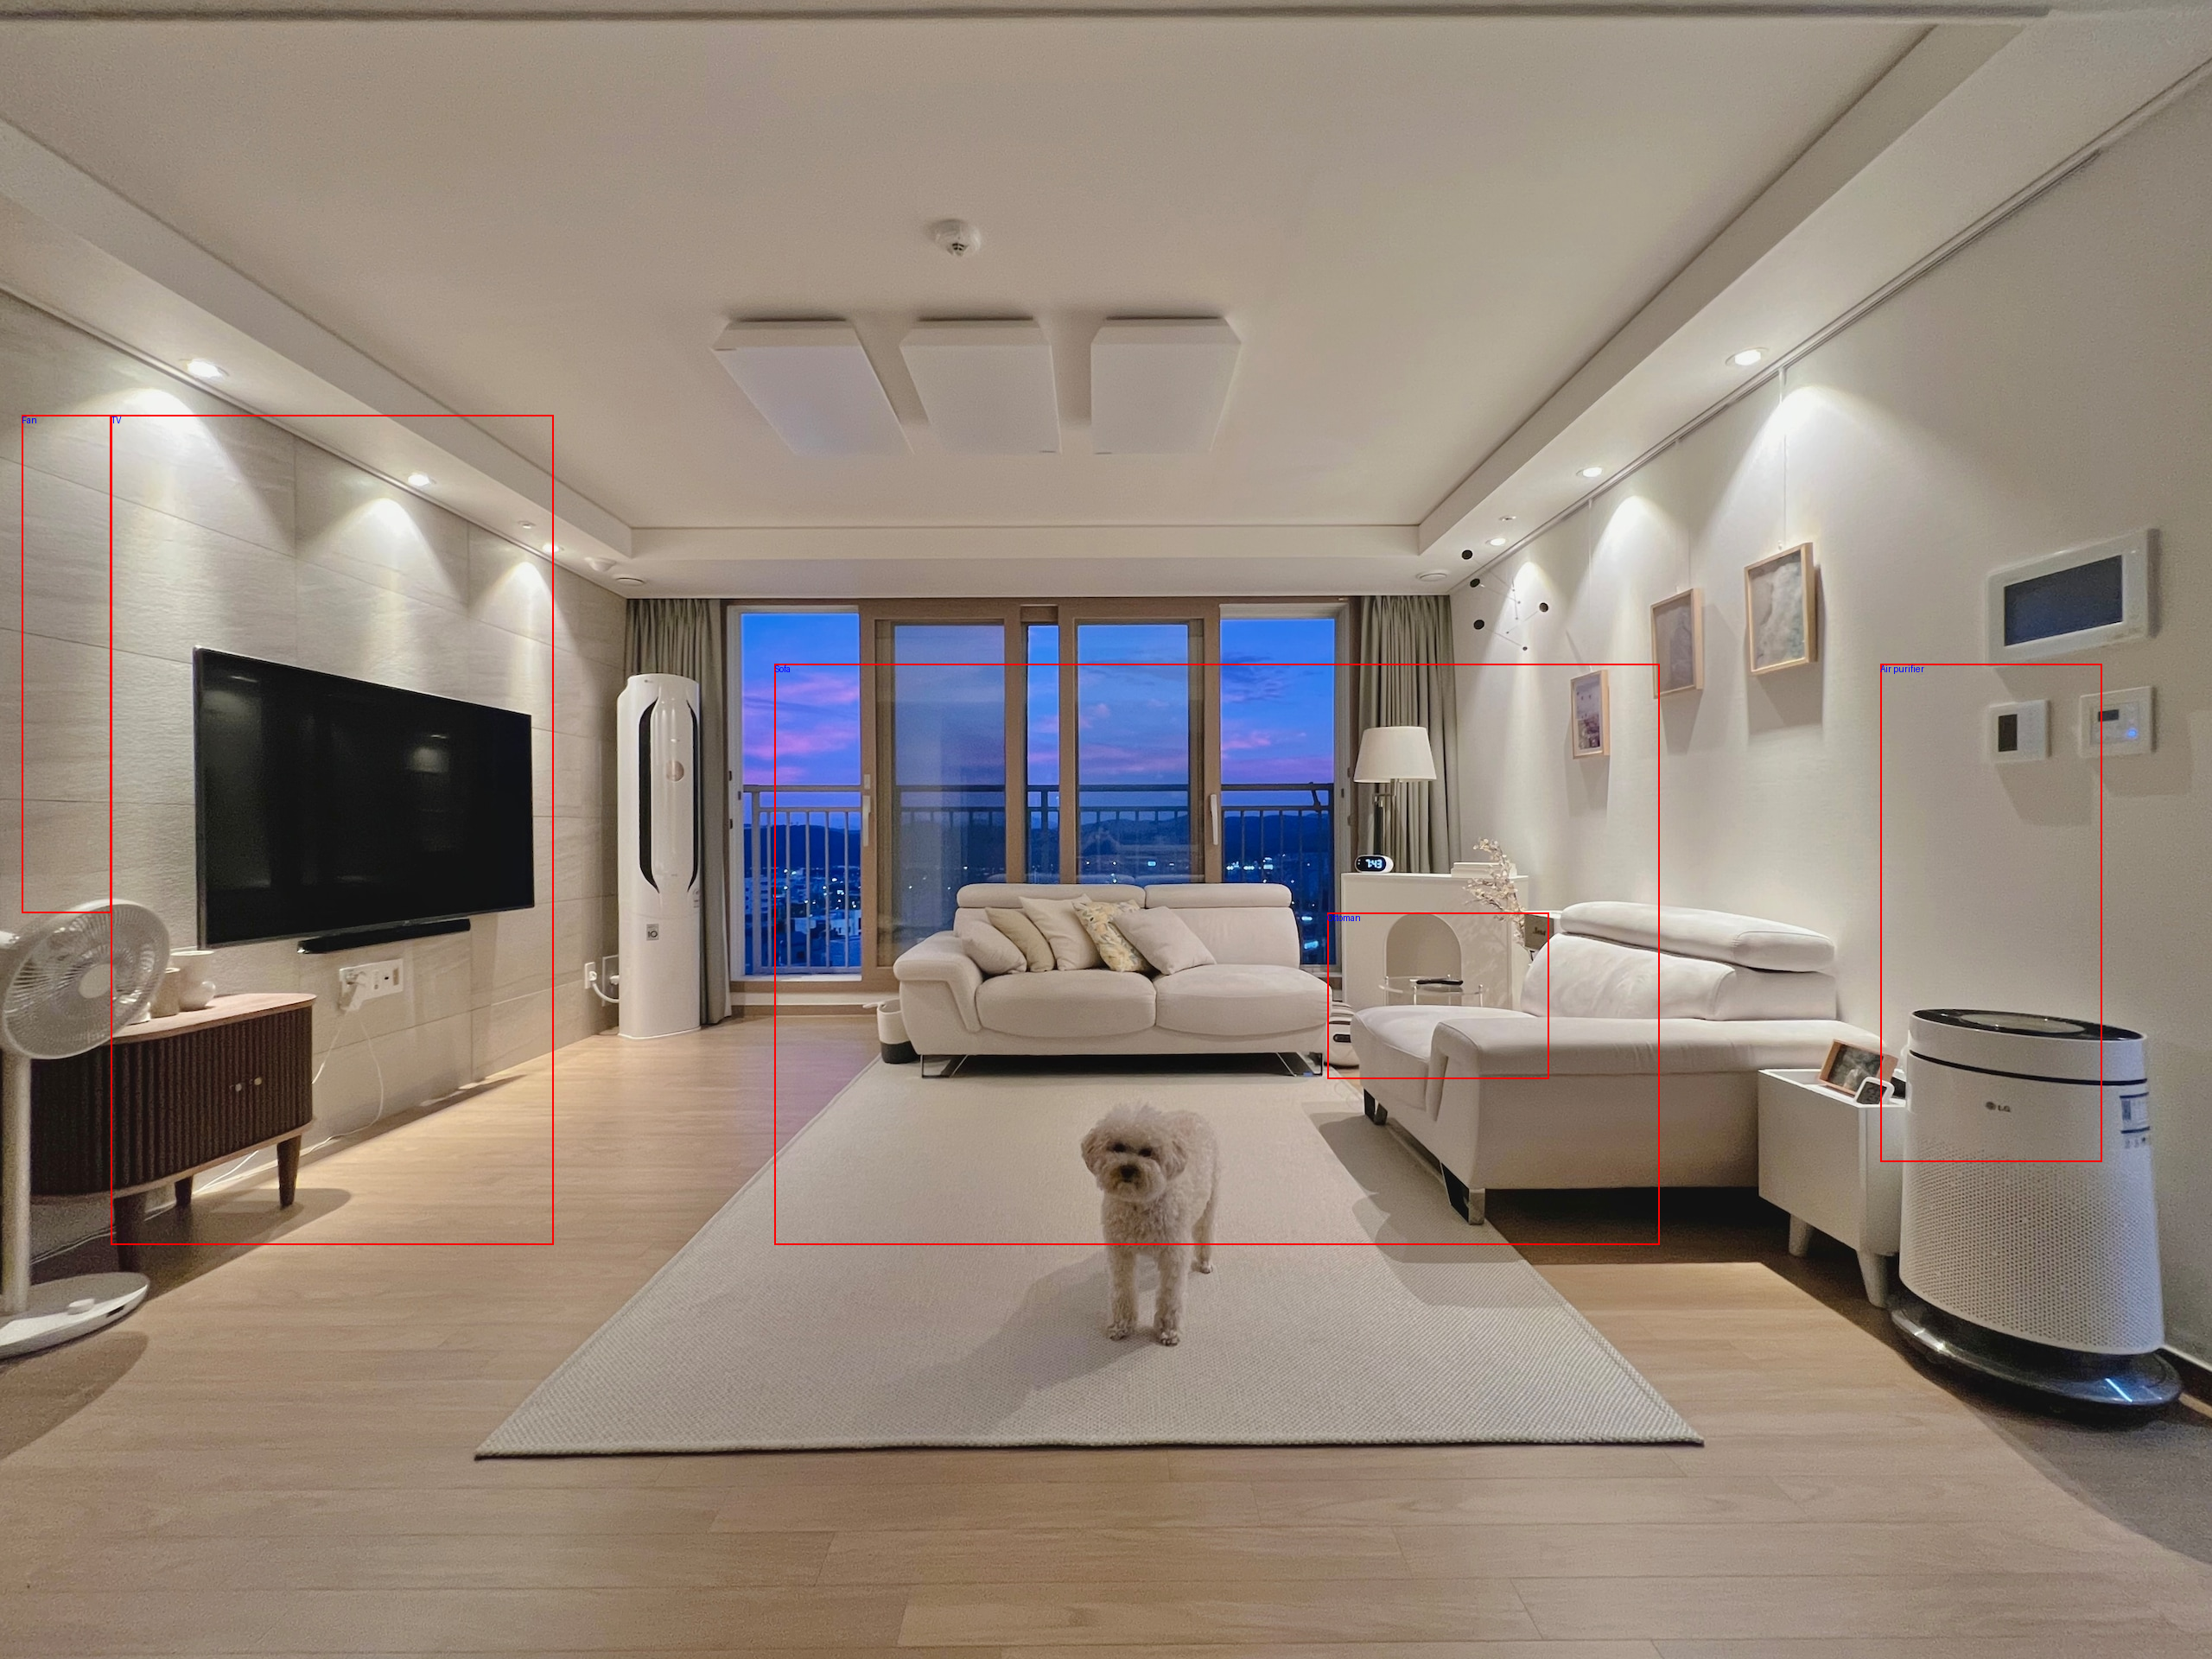

In [79]:
draw_rectangles(url = 'https://image.ohou.se/i/bucketplace-v2-development/uploads/cards/snapshots/169087905318351049.jpeg',
               upper_left_dict = output_bbg[0], bottom_right_dict = output_bbg[1])